<center>
    <h1>Generating Text with NLP</h1>
    <img width="700px" src="https://www.history.com/.image/c_fill%2Ccs_srgb%2Cfl_progressive%2Ch_400%2Cq_auto:good%2Cw_620/MTU3ODc5MDg2MTY3NjMxMTc3/plato-2.jpg">
</center>

# Introduction 

A language model can predict the probability of the next word in the sequence, based on the words already observed in the sequence. Neural network models are a preferred method for developing statistical language models because they can use a distributed representation, where different words with similar meanings have similar representation and because they can use a large context of recently observed words when making predictions.

# Goals

    1. Prepare text for developing a word-based language model.
    2. Design and fit a neural language model with a learned embedding and an LSTM hidden layer.
    3. Use the learned language model to generate new text with similar statistical properties as the source text.

# The Dataset
The Republic is the classical Greek philosopher Plato's most famous work. It is structured as a dialog on the topic of order and justice within a city state. I got the file from the Project Gutenberg's website. <a href="http://www.gutenberg.org/cache/epub/1497/pg1497.txt">Link</a> to the dataset.

# Overview

    1. The Data
    2. Data Preparation
    3. Train the Language Model
    4. Use the Language Model


## Data Preparation

The data contains 
    - chapter heading (e.g. BOOK I)
    - many punctuations, (e.g. -, ;, ?, :, etc.)
    - long monologues
    - quoted dialogs

In [2]:
# import libraries
import numpy as np
import pandas as pd
import os
import re
import string
from random import randint

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, Dense, Dropout

from keras.utils.vis_utils import plot_model

In [3]:
# load the txt file in the memory
def load_doc(file_name):
    # open the file as read-only
    file = open(file_name, "r", encoding='utf8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [4]:
# load document
in_filename = 'pg1497.txt'
doc = load_doc(in_filename)
print(doc[:800])

﻿The Project Gutenberg eBook of The Republic, by Plato

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: The Republic

Author: Plato

Translator: B. Jowett

Release Date: October, 1998 [eBook #1497]
[Most recently updated: September 11, 2021]

Language: English


Produced by: Sue Asscher and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK THE REPUBLIC ***




THE REPUBLIC

By Plato

Trans


In [5]:
# reference: https://pynative.com/python-regex-findall-finditer/
# find the beginning of the book
[m.start() for m in re.finditer('BOOK I\.', doc)]

[967, 38188, 553671]

In [6]:
# find the end of the book
[m.start() for m in re.finditer('years which we have been describing', doc)]

[1195178]

In [7]:
doc = doc[553671:1195178]

print(doc[:200])

BOOK I.


I went down yesterday to the Piraeus with Glaucon the son of Ariston,
that I might offer up my prayers to the goddess (Bendis, the Thracian
Artemis.); and also because I wanted to see in wha


## Cleaning the Text

In [8]:
# turn the doc into clean tokens
def clean_doc(doc):
    # replace "--" with a space " "
    doc = doc.replace("--", " ")
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile("[%s]" % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub("", w) for w in tokens]
    # remove the remaining tokens, which are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [9]:
# clean doc
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['book', 'i', 'i', 'went', 'down', 'yesterday', 'to', 'the', 'piraeus', 'with', 'glaucon', 'the', 'son', 'of', 'ariston', 'that', 'i', 'might', 'offer', 'up', 'my', 'prayers', 'to', 'the', 'goddess', 'bendis', 'the', 'thracian', 'artemis', 'and', 'also', 'because', 'i', 'wanted', 'to', 'see', 'in', 'what', 'manner', 'they', 'would', 'celebrate', 'the', 'festival', 'which', 'was', 'a', 'new', 'thing', 'i', 'was', 'delighted', 'with', 'the', 'procession', 'of', 'the', 'inhabitants', 'but', 'that', 'of', 'the', 'thracians', 'was', 'equally', 'if', 'not', 'more', 'beautiful', 'when', 'we', 'had', 'finished', 'our', 'prayers', 'and', 'viewed', 'the', 'spectacle', 'we', 'turned', 'in', 'the', 'direction', 'of', 'the', 'city', 'and', 'at', 'that', 'instant', 'polemarchus', 'the', 'son', 'of', 'cephalus', 'chanced', 'to', 'catch', 'sight', 'of', 'us', 'from', 'a', 'distance', 'as', 'we', 'were', 'starting', 'on', 'our', 'way', 'home', 'and', 'told', 'his', 'servant', 'to', 'run', 'and', 'bid',

### Save the Cleaned Text
Organize the long list of tokens into sequences of 50 input words and 1 output word. These are sequences of 51 words. A possible way is to iterate over the list of tokens from token 51 onwards and taking the prior 50 tokens as a sequence, then repeating this process to the end of the list of tokens. Then transform the tokens into space-separated strings for later storage in a file. 

In [10]:
# organize into sequence of tokens
length = 50 + 1
seq = list()

for i in range(length, len(tokens)):
    # select sequence of tokens
    s = tokens[i-length:i]
    # convert into a line
    line = " ".join(s)
    # store
    seq.append(line)
print("Total Sequences: %d" % len(seq))

Total Sequences: 117285


Running the above piece creates a long list of lines. Printing statistics on the list, I can see that I have exactly 117,285 training patterns to fit the model later.


Next, I can save the sequences to a new file for later loading. I can define a new function for saving lines of text to a file. This new function is called save_doc() and is listed below. It takes as input a list of lines and a filename. The lines are written, one per line, in ASCII format.

In [11]:
# save tokens to a file, one dialog per line
def save_doc(lines, filename):
    data = "\n".join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()

In [12]:
# save sequences to file
out_filename = 'sequences.txt'
save_doc(seq, out_filename)

## Prepare the Model for Training

In [13]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [14]:
# load
in_filename = 'sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

## Encode Sequences

The word embedding layer expects input sequences to be comprised of integers. Each word can be mapped in the vocabulary to a unique integer and encode the input sequences. Later, when the predictions are made, the predictions can be converted to numbers and look up their associated words in the same mapping. To do this encoding, the Tokenizer class from Keras will be used.
First, the Tokenizer must be trained on the entire training dataset, which means it finds all of the unique words in the data and assigns each a unique integer. Then use the fit Tokenizer to encode all of the training sequences, converting each sequence from a list of words to a list of integers.

In [15]:
# int encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
seq = tokenizer.texts_to_sequences(lines)

Accessing the mapping of words to integers as a dictionary attribute called word index on the Tokenizer object. The size of the vocabulary for defining the embedding layer needs to be known. To determine the vocabulary is done by calculating the size of the mapping dictionary. Words are assigned values from 1 to the total number of words (e.g. 7,323). The Embedding layer needs to allocate a vector representation for each word in this vocabulary from index 1 to the largest index and because indexing of arrays is zero-offset, the index of the word at the end of the vocabulary will be 7,323; that means the array must be 7,323 + 1 in length. Therefore, when specifying the vocabulary size to the Embedding layer, specify it as 1 larger than the actual vocabulary.

In [16]:
# vocab size
vocab_size = len(tokenizer.word_index) + 1

### Sequence Inputs and Output

Now that the input sequences are encoded, next it is needed to separate them into input (X) and output (y) elements. This could possibly be done with array slicing. After separating, it is needed to one hot encode the output word. This means converting it from an integer to a vector of 0 values, one for each word in the vocabulary, with a 1 to indicate the specific word at the index of the words integer value.
This is so that the model learns to predict the probability distribution for the next word and the ground truth from which to learn from is 0 for all words except the actual word that comes next. Keras provides the to_categorical() that can be used to one hot encode the output words for each input-output sequence pair.
Finally, it needs to be specified to the Embedding layer how long input sequences will be. I already know that there are 50 words because I made the model, but a good generic way to specify that is to use the second dimension (number of columns) of the input data's shape. That way, if I change the length of sequences when preparing data, I will not need to change this data loading code because it will be generic.

In [17]:
# split text data into input and output sequences
seq = np.array(seq)
X, y = seq[:,:-1], seq[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

### Fit the Model

I can now define and fit the language model on the training data. The learned embedding needs to know the size of the vocabulary and the length of input sequences as previously discussed. It also has a parameter to specify how many dimensions will be used to represent each word. That is, the size of the embedding vector space.
Common values are 50, 100, and 300. I will use 50 here, but maybe I will consider testing smaller or larger values. I will use a two LSTM hidden layers with 100 memory cells each. More memory cells and a deeper network may achieve better results.
A dense fully connected layer with 100 neurons connects to the LSTM hidden layers to interpret the features extracted from the sequence. The output layer predicts the next word as a single vector the size of the vocabulary with a probability for each word in the vocabulary. A softmax activation function is used to ensure the outputs have the characteristics of normalized probabilities.

<i>Reference: <a href="https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/">https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/</a></i>

In [18]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True)) # return_sequences=True makes it possible to access the hidden state output for each input time step
model.add(LSTM(100))
model.add(Dense(100, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [19]:
#compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            366200    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           60400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 7324)              739724    
                                                                 
Total params: 1,256,824
Trainable params: 1,256,824
Non-trainable params: 0
_________________________________________________________________


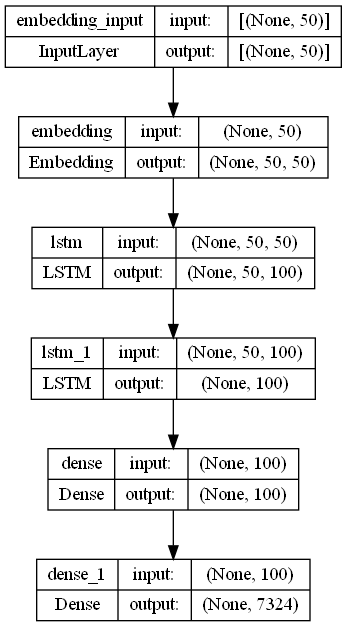

In [20]:
# summarize the defined model and plot the model
model.summary()
plot_model(model, to_file="model.png", show_shapes=True)

In [61]:
model.fit(X, y, batch_size=128, epochs=50)

Epoch 1/50
917/917 [==============================] - 296s 317ms/step - loss: 6.1516 - accuracy: 0.0744
Epoch 2/50
917/917 [==============================] - 291s 317ms/step - loss: 5.7064 - accuracy: 0.1050
Epoch 3/50
917/917 [==============================] - 268s 292ms/step - loss: 5.4846 - accuracy: 0.1280
Epoch 4/50
917/917 [==============================] - 279s 304ms/step - loss: 5.3180 - accuracy: 0.1417
Epoch 5/50
917/917 [==============================] - 265s 289ms/step - loss: 5.2043 - accuracy: 0.1504
Epoch 6/50
917/917 [==============================] - 267s 291ms/step - loss: 5.1115 - accuracy: 0.1573
Epoch 7/50
917/917 [==============================] - 275s 299ms/step - loss: 5.0295 - accuracy: 0.1622
Epoch 8/50
917/917 [==============================] - 266s 290ms/step - loss: 4.9529 - accuracy: 0.1670
Epoch 9/50
917/917 [==============================] - 290s 317ms/step - loss: 4.8774 - accuracy: 0.1716
Epoch 10/50
917/917 [==============================] - 277s 302m

In [64]:
from joblib import dump
# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

## Use the Model
Now that the model has trained a bit (4 hours), I can use it. In this case, I can use it to generate new sequences of text that have the same statistical properties as the source text.I will start by loading the training sequences again.

In [21]:
# it's not very practical to load the same function again but it'll work for testing
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load cleaned text sequences
in_filename = 'pg1497.txt'
doc = load_doc(in_filename, )
lines = doc.split('\n')

I need the text so that I can choose a source sequence as input to the model for generating a new sequence of text. The model will require 50 words as input. Later, I will need to specify the expected length of input. I can determine this from the input sequences by calculating the length of one line of the loaded data and subtracting 1 for the expected output word that is also on the same line.

In [22]:
seq_length = len(lines[0].split()) - 1

### Load the Model

In [26]:
import h5py

In [32]:
from tensorflow import keras

# load the model
# model = keras.models.load_model('model.h5')

In [90]:
# import socket
# # load the tokenizer
# tokenizer = load(open('tokenizer.pkl', 'rb'))

In [33]:
# select a seed text
# seed_text = lines[randint(0,len(lines))]
# print(seed_text + '\n')

In [34]:
# encoded = tokenizer.texts_to_sequences([seed_text])[0]